# Benchmark an Endpoint

Welcome to this tutorial on benchmarking an endpoint deployed on a SambaNova dedicated node!

If you don't already have an endpoint deployed, please follow one of the workflows described in the [README](./README.md) to deploy an endpoint before proceeding with this tutorial.

Also, please install the benchmarking requirements in the Python kernel used in this Jupyter notebook

`! pip install -r ../../benchmarking/requirements.txt`

## 1.  Imports

In [1]:
import sys
sys.version

'3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
import json
import os
import pprint
import getpass
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
benchmarking_dir = "../../benchmarking/"
sys.path.append(benchmarking_dir + "benchmarking_scripts")
sys.path.append(benchmarking_dir + "prompts")
from synthetic_performance_eval_script import *

## 2. Get endpoint info
To benchmark the endpoint, we will need to obtain some of its information. Note that this information can be obtained from your SambaNova representative.

#### Enter the endpoint url
Run the cell below and then enter the endpoint URL. This should be in the format of `https://my.env/v1/<endpoint_id>/chat/completions` 

In [4]:
endpoint_url = input().strip()
if endpoint_url[-1] == "/":
    endpoint_url = endpoint_url[:-1]
os.environ["SAMBASTUDIO_URL"] = endpoint_url
endpoint_id = endpoint_url.split('/')[-3]
print("Benchmarking Endpoint:", endpoint_id)

Benchmarking Endpoint: 9b25868d-a1ee-4604-a5b8-e5ffaf3a3305


#### Enter the endpoint API key

In [5]:
endpoint_key = getpass.getpass().strip()
if len(endpoint_key) > 0:
    os.environ["SAMBASTUDIO_API_KEY"] = endpoint_key
else:
    print("Please enter a valid key")

## 3. Automatically retrieve model list from endpoint (Optional)
Run this section only if you don't the have list of models on the endpoint. Note that running this section requires you to first follow the set up instructions given in the [README](./README.md)
#### Set up environment connector
The connector connects to the remote dedicated environment using the variables defined below

In [6]:
env_url = '/'.join(endpoint_url.split('/')[:3])

In [7]:
print("Enter the env access key")
env_key = getpass.getpass().strip()
if len(env_key) > 0:
    os.environ["SAMBASTUDIO_ACCESS_KEY"] = env_key
else:
    print("Please enter a valid key")

Enter the env access key


In [8]:
env_tenant = "default"

In [9]:
from snsdk import SnSdk
sn_env = SnSdk(host_url=env_url, 
                   access_key=env_key, 
                   tenant_id=env_tenant)

#### Get model names in the endpoint

In [10]:
endpoint_info = sn_env.endpoint_info_by_id(endpoint_id)
endpoint_model_id = endpoint_info['targets'][0]["model"]
model_info = sn_env.model_info(endpoint_model_id, job_type="deploy")
model_constituents = [m["name"] for m in model_info["dependencies"]]
sorted(model_constituents)

['Meta-Llama-3.2-11B-Vision-Instruct',
 'Meta-Llama-3.2-1B-Instruct',
 'Meta-Llama-3.3-70B-SD-Llama-3.2-1B-TP16',
 'Mistral-7B-Instruct-V0.2',
 'Qwen2.5-0.5B-Instruct']

#### Get target model names in the endpoint
Target model names generally differ from model names when the model is a speculative decoding pair

In [11]:
target_models = []
for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name
    target_models.append(model_name)
sorted(target_models)

['Meta-Llama-3.2-11B-Vision-Instruct',
 'Meta-Llama-3.2-1B-Instruct',
 'Meta-Llama-3.3-70B-Instruct',
 'Mistral-7B-Instruct-V0.2',
 'Qwen2.5-0.5B-Instruct']

## 4. Set up Model Configs for Benchmarking
Note that this section only currently supports a fraction of what the Benchmarking Kit is capable of. You may repurpose this section if you would like to benchmark images or run questions per second (qps).

#### Specify target models
If not automatically set in Step 3, set Target models as a python list

In [6]:
target_models = ["Meta-Llama-3.3-70B-Instruct"]

#### Specify combinatorial inputs for benchmarking

In [7]:
input_tokens = [3900, 8000, 16000]
output_tokens = [100]
num_requests = [64]
concurrent_requests = [1, 2, 4, 8, 16, 32]

#### Automatically generate configs

In [8]:
model_configs_df = pd.DataFrame(columns=[
                "model_name",
                "input_tokens",
                "output_tokens",
                "num_requests",
                "concurrent_requests"
                ])
counter = 1
for target_model in target_models:
    for input_token in input_tokens:
        for output_token in output_tokens:
            for num_request in num_requests:
                for concurrent_request in concurrent_requests:
                    model_configs_df.loc[counter] = [
                                        target_model, 
                                        input_token,
                                        output_token,
                                        num_request,
                                        concurrent_request
                                    ]
                    counter += 1


#### Confirm model configs and delete any configs that you would rather exclude

In [9]:
drop_rows = model_configs_df[(model_configs_df["model_name"] == "Qwen2.5-72B-Instruct") &
            (model_configs_df["input_tokens"] > 3900)].index.tolist()
model_configs_df.drop(drop_rows, inplace=True)
model_configs_df

,model_name,input_tokens,output_tokens,num_requests,concurrent_requests
1,Meta-Llama-3.3-70B-Instruct,3900,100,64,1
2,Meta-Llama-3.3-70B-Instruct,3900,100,64,2
3,Meta-Llama-3.3-70B-Instruct,3900,100,64,4
4,Meta-Llama-3.3-70B-Instruct,3900,100,64,8
5,Meta-Llama-3.3-70B-Instruct,3900,100,64,16
6,Meta-Llama-3.3-70B-Instruct,3900,100,64,32
7,Meta-Llama-3.3-70B-Instruct,8000,100,64,1
8,Meta-Llama-3.3-70B-Instruct,8000,100,64,2
9,Meta-Llama-3.3-70B-Instruct,8000,100,64,4
10,Meta-Llama-3.3-70B-Instruct,8000,100,64,8


## 5. Run Benchmarking
We will run benchmarking with the configs now

#### Name the benchmarking run
Give the run a unique name so that the configs and results can be saved with that name. Please note that the name should be compatible with file system path naming rules.

In [10]:
run_name = "dso-llama33_70_short_20250611_1"

#### Configure saving options
Saving makes it easy to re-run the model configs by skipping all the above sections

In [11]:
output_path = f"{benchmarking_dir}data/benchmarking_tracking_tests/"
config = {
    'model_configs_path': f'{output_path}model_configs_{run_name}.csv', # leave this as is
    'llm_api': 'sambastudio', # leave this as is
    'output_files_dir': f'{output_path}logs/output_files', # each run saved here
    'consolidated_results_dir': f'{output_path}consolidated_results', # consolidated xlsx saved here
    'timeout': 3600,
    'time_delay': 0, # between batches of concurrent requests
}

#### Save configs

In [12]:
with open(f"{output_path}config_{run_name}.yaml", "w") as f:
    yaml.dump(config, f, default_flow_style=False)
model_configs_df.to_csv(config["model_configs_path"], index=False)

#### Run configs

In [13]:
run_benchmarking(config=config, benchmarking_dir=benchmarking_dir, run_name=run_name)

2025-06-11 17:25:23,806 [INFO] Running model_name Meta-Llama-3.3-70B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:59<00:00,  1.14it/s]

2025-06-11 17:26:24,286 [INFO] Tasks Executed!
2025-06-11 17:26:24,287 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:26:24,318 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:26:24,322 [INFO]     p5 = 0.5493
2025-06-11 17:26:24,322 [INFO]     p25 = 0.5816
2025-06-11 17:26:24,323 [INFO]     p50 = 0.6126
2025-06-11 17:26:24,323 [INFO]     p75 = 0.6962
2025-06-11 17:26:24,324 [INFO]     p90 = 0.7507
2025-06-11 17:26:24,324 [INFO]     p95 = 0.7782
2025-06-11 17:26:24,324 [INFO]     p99 = 2.4449
2025-06-11 17:26:24,325 [INFO]     mean = 0.7092
2025-06-11 17:26:24,326 [INFO]     min = 0.543
2025-06-11 17:26:24,326 [INFO]     max = 5.2633
2025-06-11 17:26:24,326 [INFO]     stddev = 0.5827
2025-06-11 17:26:24,326 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:26:24,328 [INFO]     p5 = 0.7588
2025-06-11 17:26:24,328 [INFO]     p25 = 0.789
2025

Running Requests: 100%|██████████| 64/64 [00:39<00:00,  1.52it/s]

2025-06-11 17:27:04,884 [INFO] Tasks Executed!
2025-06-11 17:27:04,885 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:27:04,907 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:27:04,910 [INFO]     p5 = 0.832
2025-06-11 17:27:04,910 [INFO]     p25 = 1.0155
2025-06-11 17:27:04,910 [INFO]     p50 = 1.0196
2025-06-11 17:27:04,911 [INFO]     p75 = 1.0242
2025-06-11 17:27:04,911 [INFO]     p90 = 1.0291
2025-06-11 17:27:04,912 [INFO]     p95 = 1.0554
2025-06-11 17:27:04,912 [INFO]     p99 = 1.1354
2025-06-11 17:27:04,913 [INFO]     mean = 0.9954
2025-06-11 17:27:04,913 [INFO]     min = 0.5554
2025-06-11 17:27:04,914 [INFO]     max = 1.1729
2025-06-11 17:27:04,914 [INFO]     stddev = 0.0863
2025-06-11 17:27:04,915 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:27:04,916 [INFO]     p5 = 1.0605
2025-06-11 17:27:04,916 [INFO]     p25 = 1.2237
202

Running Requests: 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]

2025-06-11 17:27:39,552 [INFO] Tasks Executed!
2025-06-11 17:27:39,554 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:27:39,573 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:27:39,577 [INFO]     p5 = 1.5726
2025-06-11 17:27:39,577 [INFO]     p25 = 1.5766
2025-06-11 17:27:39,578 [INFO]     p50 = 1.5795
2025-06-11 17:27:39,578 [INFO]     p75 = 1.5924
2025-06-11 17:27:39,579 [INFO]     p90 = 1.6492
2025-06-11 17:27:39,580 [INFO]     p95 = 4.8926
2025-06-11 17:27:39,580 [INFO]     p99 = 6.385
2025-06-11 17:27:39,581 [INFO]     mean = 1.8583
2025-06-11 17:27:39,582 [INFO]     min = 1.5686
2025-06-11 17:27:39,582 [INFO]     max = 6.3856
2025-06-11 17:27:39,583 [INFO]     stddev = 1.0648
2025-06-11 17:27:39,583 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:27:39,585 [INFO]     p5 = 1.7948
2025-06-11 17:27:39,586 [INFO]     p25 = 1.8001
202

Running Requests:  91%|█████████ | 58/64 [00:31<00:05,  1.19it/s]

2025-06-11 17:28:12,361 [INFO] Tasks Executed!
2025-06-11 17:28:12,362 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:28:12,376 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:28:12,378 [INFO]     p5 = 3.0918
2025-06-11 17:28:12,379 [INFO]     p25 = 3.1017
2025-06-11 17:28:12,379 [INFO]     p50 = 3.1069
2025-06-11 17:28:12,379 [INFO]     p75 = 3.1504
2025-06-11 17:28:12,380 [INFO]     p90 = 7.7043
2025-06-11 17:28:12,380 [INFO]     p95 = 7.74
2025-06-11 17:28:12,380 [INFO]     p99 = 7.741
2025-06-11 17:28:12,381 [INFO]     mean = 3.6536
2025-06-11 17:28:12,381 [INFO]     min = 0.5451
2025-06-11 17:28:12,382 [INFO]     max = 7.741
2025-06-11 17:28:12,382 [INFO]     stddev = 1.5845
2025-06-11 17:28:12,382 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:28:12,384 [INFO]     p5 = 3.3529
2025-06-11 17:28:12,384 [INFO]     p25 = 3.366
2025-06

Running Requests: 100%|██████████| 64/64 [00:27<00:00,  1.93it/s]

2025-06-11 17:28:41,123 [INFO] Tasks Executed!
2025-06-11 17:28:41,124 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:28:41,140 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:28:41,142 [INFO]     p5 = 5.3359
2025-06-11 17:28:41,143 [INFO]     p25 = 5.344
2025-06-11 17:28:41,143 [INFO]     p50 = 5.3498
2025-06-11 17:28:41,144 [INFO]     p75 = 6.733
2025-06-11 17:28:41,144 [INFO]     p90 = 10.5059
2025-06-11 17:28:41,144 [INFO]     p95 = 10.5089
2025-06-11 17:28:41,145 [INFO]     p99 = 10.5127
2025-06-11 17:28:41,146 [INFO]     mean = 6.5669
2025-06-11 17:28:41,146 [INFO]     min = 0.5731
2025-06-11 17:28:41,146 [INFO]     max = 10.5141
2025-06-11 17:28:41,147 [INFO]     stddev = 2.3688
2025-06-11 17:28:41,147 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:28:41,148 [INFO]     p5 = 5.6671
2025-06-11 17:28:41,148 [INFO]     p25 = 5.6742


Running Requests:  83%|████████▎ | 53/64 [00:36<00:07,  1.41it/s]

2025-06-11 17:29:18,419 [INFO] Tasks Executed!
2025-06-11 17:29:18,420 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:29:18,436 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:29:18,438 [INFO]     p5 = 14.9134
2025-06-11 17:29:18,438 [INFO]     p25 = 14.9249
2025-06-11 17:29:18,438 [INFO]     p50 = 15.1368
2025-06-11 17:29:18,439 [INFO]     p75 = 15.2119
2025-06-11 17:29:18,439 [INFO]     p90 = 20.4482
2025-06-11 17:29:18,440 [INFO]     p95 = 20.4511
2025-06-11 17:29:18,441 [INFO]     p99 = 20.454
2025-06-11 17:29:18,443 [INFO]     mean = 16.0033
2025-06-11 17:29:18,444 [INFO]     min = 0.6146
2025-06-11 17:29:18,445 [INFO]     max = 20.4544
2025-06-11 17:29:18,445 [INFO]     stddev = 2.9571
2025-06-11 17:29:18,446 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:29:18,449 [INFO]     p5 = 15.3816
2025-06-11 17:29:18,451 [INFO]     p25 = 

Running Requests: 100%|██████████| 64/64 [01:41<00:00,  1.52s/it]

2025-06-11 17:31:00,601 [INFO] Tasks Executed!
2025-06-11 17:31:00,602 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:31:00,631 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:31:00,633 [INFO]     p5 = 1.1253
2025-06-11 17:31:00,634 [INFO]     p25 = 1.1668
2025-06-11 17:31:00,634 [INFO]     p50 = 1.2359
2025-06-11 17:31:00,634 [INFO]     p75 = 1.3131
2025-06-11 17:31:00,635 [INFO]     p90 = 1.3675
2025-06-11 17:31:00,635 [INFO]     p95 = 1.4175
2025-06-11 17:31:00,636 [INFO]     p99 = 2.4586
2025-06-11 17:31:00,637 [INFO]     mean = 1.2875
2025-06-11 17:31:00,638 [INFO]     min = 1.105
2025-06-11 17:31:00,639 [INFO]     max = 4.1907
2025-06-11 17:31:00,640 [INFO]     stddev = 0.3785
2025-06-11 17:31:00,640 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:31:00,643 [INFO]     p5 = 1.385
2025-06-11 17:31:00,643 [INFO]     p25 = 1.4485
2025

Running Requests: 100%|██████████| 64/64 [01:17<00:00,  1.18s/it]

2025-06-11 17:32:18,917 [INFO] Tasks Executed!
2025-06-11 17:32:18,919 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:32:18,952 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:32:18,957 [INFO]     p5 = 1.9516
2025-06-11 17:32:18,958 [INFO]     p25 = 2.0708
2025-06-11 17:32:18,959 [INFO]     p50 = 2.1376
2025-06-11 17:32:18,959 [INFO]     p75 = 2.1583
2025-06-11 17:32:18,959 [INFO]     p90 = 2.175
2025-06-11 17:32:18,960 [INFO]     p95 = 2.2295
2025-06-11 17:32:18,960 [INFO]     p99 = 2.3093
2025-06-11 17:32:18,961 [INFO]     mean = 2.0988
2025-06-11 17:32:18,962 [INFO]     min = 1.1242
2025-06-11 17:32:18,963 [INFO]     max = 2.4159
2025-06-11 17:32:18,964 [INFO]     stddev = 0.1509
2025-06-11 17:32:18,966 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:32:18,968 [INFO]     p5 = 2.2514
2025-06-11 17:32:18,971 [INFO]     p25 = 2.3536
202

Running Requests: 100%|██████████| 64/64 [01:27<00:00,  1.63s/it]

2025-06-11 17:33:48,080 [INFO] Tasks Executed!
2025-06-11 17:33:48,081 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:33:48,099 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:33:48,102 [INFO]     p5 = 4.963
2025-06-11 17:33:48,102 [INFO]     p25 = 4.969
2025-06-11 17:33:48,103 [INFO]     p50 = 4.9767
2025-06-11 17:33:48,103 [INFO]     p75 = 5.0174
2025-06-11 17:33:48,104 [INFO]     p90 = 5.0661
2025-06-11 17:33:48,104 [INFO]     p95 = 7.4949
2025-06-11 17:33:48,104 [INFO]     p99 = 8.0721
2025-06-11 17:33:48,105 [INFO]     mean = 5.1208
2025-06-11 17:33:48,106 [INFO]     min = 1.1249
2025-06-11 17:33:48,107 [INFO]     max = 8.0741
2025-06-11 17:33:48,107 [INFO]     stddev = 0.8997
2025-06-11 17:33:48,107 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:33:48,109 [INFO]     p5 = 5.2596
2025-06-11 17:33:48,109 [INFO]     p25 = 5.2715
2025

Running Requests:  92%|█████████▏| 59/64 [01:16<00:16,  3.29s/it]

2025-06-11 17:35:05,210 [INFO] Tasks Executed!
2025-06-11 17:35:05,211 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:35:05,230 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:35:05,234 [INFO]     p5 = 8.5666
2025-06-11 17:35:05,234 [INFO]     p25 = 8.5827
2025-06-11 17:35:05,235 [INFO]     p50 = 8.6074
2025-06-11 17:35:05,235 [INFO]     p75 = 8.6646
2025-06-11 17:35:05,235 [INFO]     p90 = 12.9889
2025-06-11 17:35:05,236 [INFO]     p95 = 13.0274
2025-06-11 17:35:05,236 [INFO]     p99 = 13.0286
2025-06-11 17:35:05,237 [INFO]     mean = 9.0443
2025-06-11 17:35:05,237 [INFO]     min = 1.1259
2025-06-11 17:35:05,238 [INFO]     max = 13.0293
2025-06-11 17:35:05,238 [INFO]     stddev = 1.7777
2025-06-11 17:35:05,239 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:35:05,240 [INFO]     p5 = 8.9372
2025-06-11 17:35:05,241 [INFO]     p25 = 8.944

Running Requests: 100%|██████████| 64/64 [01:09<00:00,  2.73s/it]

2025-06-11 17:36:15,294 [INFO] Tasks Executed!
2025-06-11 17:36:15,295 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:36:15,312 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:36:15,315 [INFO]     p5 = 15.8441
2025-06-11 17:36:15,316 [INFO]     p25 = 15.8668
2025-06-11 17:36:15,316 [INFO]     p50 = 15.8887
2025-06-11 17:36:15,317 [INFO]     p75 = 16.8762
2025-06-11 17:36:15,318 [INFO]     p90 = 19.081
2025-06-11 17:36:15,319 [INFO]     p95 = 19.083
2025-06-11 17:36:15,320 [INFO]     p99 = 19.116
2025-06-11 17:36:15,321 [INFO]     mean = 16.4561
2025-06-11 17:36:15,322 [INFO]     min = 1.1763
2025-06-11 17:36:15,322 [INFO]     max = 19.1667
2025-06-11 17:36:15,323 [INFO]     stddev = 2.3888
2025-06-11 17:36:15,324 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:36:15,325 [INFO]     p5 = 16.3765
2025-06-11 17:36:15,326 [INFO]     p25 = 16

Running Requests:  78%|███████▊  | 50/64 [01:02<00:29,  2.12s/it]

2025-06-11 17:37:18,663 [INFO] Tasks Executed!
2025-06-11 17:37:18,664 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:37:18,680 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:37:18,682 [INFO]     p5 = 16.2391
2025-06-11 17:37:18,682 [INFO]     p25 = 16.2671
2025-06-11 17:37:18,683 [INFO]     p50 = 29.8318
2025-06-11 17:37:18,683 [INFO]     p75 = 29.8561
2025-06-11 17:37:18,683 [INFO]     p90 = 31.3588
2025-06-11 17:37:18,684 [INFO]     p95 = 31.363
2025-06-11 17:37:18,684 [INFO]     p99 = 31.3694
2025-06-11 17:37:18,685 [INFO]     mean = 26.3488
2025-06-11 17:37:18,685 [INFO]     min = 1.2578
2025-06-11 17:37:18,686 [INFO]     max = 31.372
2025-06-11 17:37:18,686 [INFO]     stddev = 6.9316
2025-06-11 17:37:18,686 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:37:18,688 [INFO]     p5 = 16.6834
2025-06-11 17:37:18,688 [INFO]     p25 = 1

Running Requests: 100%|██████████| 64/64 [02:45<00:00,  2.53s/it]

2025-06-11 17:40:05,263 [INFO] Tasks Executed!
2025-06-11 17:40:05,265 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:40:05,289 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:40:05,291 [INFO]     p5 = 2.0931
2025-06-11 17:40:05,291 [INFO]     p25 = 2.1307
2025-06-11 17:40:05,292 [INFO]     p50 = 2.1834
2025-06-11 17:40:05,292 [INFO]     p75 = 2.229
2025-06-11 17:40:05,293 [INFO]     p90 = 2.2994
2025-06-11 17:40:05,293 [INFO]     p95 = 2.3557
2025-06-11 17:40:05,294 [INFO]     p99 = 3.9658
2025-06-11 17:40:05,294 [INFO]     mean = 2.2581
2025-06-11 17:40:05,295 [INFO]     min = 2.0734
2025-06-11 17:40:05,295 [INFO]     max = 6.6783
2025-06-11 17:40:05,295 [INFO]     stddev = 0.5662
2025-06-11 17:40:05,296 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:40:05,298 [INFO]     p5 = 2.4102
2025-06-11 17:40:05,298 [INFO]     p25 = 2.4523
202

Running Requests: 100%|██████████| 64/64 [02:22<00:00,  2.23s/it]

2025-06-11 17:42:28,643 [INFO] Tasks Executed!
2025-06-11 17:42:28,644 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:42:28,665 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:42:28,667 [INFO]     p5 = 3.9699
2025-06-11 17:42:28,667 [INFO]     p25 = 4.0724
2025-06-11 17:42:28,668 [INFO]     p50 = 4.1031
2025-06-11 17:42:28,668 [INFO]     p75 = 4.1225
2025-06-11 17:42:28,669 [INFO]     p90 = 4.1368
2025-06-11 17:42:28,669 [INFO]     p95 = 4.1467
2025-06-11 17:42:28,669 [INFO]     p99 = 4.1983
2025-06-11 17:42:28,670 [INFO]     mean = 4.0617
2025-06-11 17:42:28,671 [INFO]     min = 2.0722
2025-06-11 17:42:28,671 [INFO]     max = 4.2801
2025-06-11 17:42:28,671 [INFO]     stddev = 0.2585
2025-06-11 17:42:28,672 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:42:28,673 [INFO]     p5 = 4.3494
2025-06-11 17:42:28,674 [INFO]     p25 = 4.4074
20

Running Requests: 100%|██████████| 64/64 [02:57<00:00,  3.71s/it]

2025-06-11 17:45:27,222 [INFO] Tasks Executed!
2025-06-11 17:45:27,224 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:45:27,243 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:45:27,246 [INFO]     p5 = 10.3229
2025-06-11 17:45:27,246 [INFO]     p25 = 10.3348
2025-06-11 17:45:27,246 [INFO]     p50 = 10.3719
2025-06-11 17:45:27,247 [INFO]     p75 = 10.4035
2025-06-11 17:45:27,247 [INFO]     p90 = 10.4219
2025-06-11 17:45:27,248 [INFO]     p95 = 15.2623
2025-06-11 17:45:27,248 [INFO]     p99 = 16.4278
2025-06-11 17:45:27,249 [INFO]     mean = 10.6124
2025-06-11 17:45:27,250 [INFO]     min = 2.087
2025-06-11 17:45:27,250 [INFO]     max = 16.4284
2025-06-11 17:45:27,251 [INFO]     stddev = 1.8171
2025-06-11 17:45:27,251 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:45:27,253 [INFO]     p5 = 10.7039
2025-06-11 17:45:27,253 [INFO]     p25 = 

Running Requests:  97%|█████████▋| 62/64 [02:18<00:07,  3.60s/it]

2025-06-11 17:47:46,675 [INFO] Tasks Executed!
2025-06-11 17:47:46,677 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:47:46,785 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:47:46,789 [INFO]     p5 = 10.552
2025-06-11 17:47:46,790 [INFO]     p25 = 16.626
2025-06-11 17:47:46,790 [INFO]     p50 = 16.6452
2025-06-11 17:47:46,790 [INFO]     p75 = 16.6774
2025-06-11 17:47:46,791 [INFO]     p90 = 16.7319
2025-06-11 17:47:46,791 [INFO]     p95 = 16.7468
2025-06-11 17:47:46,791 [INFO]     p99 = 19.0584
2025-06-11 17:47:46,792 [INFO]     mean = 16.1603
2025-06-11 17:47:46,793 [INFO]     min = 2.1008
2025-06-11 17:47:46,793 [INFO]     max = 19.0587
2025-06-11 17:47:46,793 [INFO]     stddev = 2.3991
2025-06-11 17:47:46,793 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:47:46,795 [INFO]     p5 = 10.9372
2025-06-11 17:47:46,795 [INFO]     p25 = 1

Running Requests: 100%|██████████| 64/64 [02:18<00:00,  4.16s/it]

2025-06-11 17:50:06,725 [INFO] Tasks Executed!
2025-06-11 17:50:06,729 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:50:06,765 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:50:06,769 [INFO]     p5 = 10.6465
2025-06-11 17:50:06,770 [INFO]     p25 = 33.6296
2025-06-11 17:50:06,771 [INFO]     p50 = 33.6355
2025-06-11 17:50:06,771 [INFO]     p75 = 33.6442
2025-06-11 17:50:06,772 [INFO]     p90 = 33.7125
2025-06-11 17:50:06,772 [INFO]     p95 = 33.7458
2025-06-11 17:50:06,773 [INFO]     p99 = 36.1912
2025-06-11 17:50:06,774 [INFO]     mean = 30.5573
2025-06-11 17:50:06,774 [INFO]     min = 2.2132
2025-06-11 17:50:06,775 [INFO]     max = 36.1927
2025-06-11 17:50:06,775 [INFO]     stddev = 7.4508
2025-06-11 17:50:06,776 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:50:06,778 [INFO]     p5 = 11.0279
2025-06-11 17:50:06,779 [INFO]     p25 =

Running Requests: 100%|██████████| 64/64 [02:18<00:00,  1.93s/it]

2025-06-11 17:52:26,588 [INFO] Tasks Executed!
2025-06-11 17:52:26,590 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-06-11 17:52:26,611 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-06-11 17:52:26,613 [INFO]     p5 = 10.7549
2025-06-11 17:52:26,614 [INFO]     p25 = 36.3027
2025-06-11 17:52:26,614 [INFO]     p50 = 67.6504
2025-06-11 17:52:26,615 [INFO]     p75 = 67.6757
2025-06-11 17:52:26,615 [INFO]     p90 = 67.705
2025-06-11 17:52:26,615 [INFO]     p95 = 67.709
2025-06-11 17:52:26,616 [INFO]     p99 = 70.3259
2025-06-11 17:52:26,617 [INFO]     mean = 53.0484
2025-06-11 17:52:26,617 [INFO]     min = 2.314
2025-06-11 17:52:26,617 [INFO]     max = 70.3272
2025-06-11 17:52:26,618 [INFO]     stddev = 20.4294
2025-06-11 17:52:26,618 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-06-11 17:52:26,619 [INFO]     p5 = 11.1412
2025-06-11 17:52:26,620 [INFO]     p25 = 3

## 6. Visualize results

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

def plot_benchmarking_data(df, ylabel, ycol, model):    
    df = df.reset_index()
    # Create a new column combining 'in' and 'out' into a single legend label
    df['in_out'] = df.apply(lambda row: f"({row['num_input_tokens']}, {row['num_output_tokens']})", axis=1)

    plt.figure(figsize=(8, 5))
    
    palette = sns.color_palette("tab10", n_colors=df['in_out'].nunique())

    # Plot main performance metric
    for i, in_out in enumerate(df['in_out'].unique()):
        selected_df = df[df['in_out'] == in_out]
        sns.lineplot(data=selected_df, x='num_concurrent_requests', y=ycol, marker='o', linewidth=2, color=palette[i], label=in_out)        
    
    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks to show real numbers instead of 2^n notation
    xticks = sorted(df['num_concurrent_requests'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    plt.title(f"{model}: {ylabel}")
    
    plt.legend(title="(input, output)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, which="both", linestyle="--")
    
    plt.show()

#### Read results from current run

In [16]:
current_file_path = os.path.join(config["consolidated_results_dir"], f'{run_name}.xlsx')
df_current = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_current.head()

,uuid,name,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_mean,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_mean,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_mean,server_output_token_per_s_p50,server_output_token_per_s_max,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_mean,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_mean,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_mean,client_output_token_per_s_p50,client_output_token_per_s_max,client_total_output_throughput,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size
0,5350fa2a-fb50-4c60-88e7-a8c8a6bb6923,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,1,0.3801,0.4535,0.3828,4.8994,0.5897,0.6655,0.5949,5.1213,325.4260,455.8141,458.8224,463.3246,NaN,NaN,NaN,3934,100,0.5430,0.7092,0.6126,5.2633,0.7473,0.9275,0.8365,5.5294,238.0279,486.8544,475.8591,969.9172,107.3808,64,64,64.4285,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,5f656193-5269-4b96-a64c-8d173e701ea6,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,2,0.3799,0.3821,0.3821,0.3849,0.5899,0.5923,0.5922,0.5980,457.8672,462.4326,462.5537,465.3559,NaN,NaN,NaN,3934,100,0.5554,0.9954,1.0196,1.1729,0.7643,1.2275,1.2291,1.5308,195.0505,453.1132,478.0268,856.4231,160.8371,64,64,96.5022,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,96d44ff5-31af-4e3c-8453-daf145437886,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,4,0.6500,0.7929,0.6516,5.1575,0.8743,1.0191,0.8778,5.3891,323.1098,425.1677,430.4605,433.1878,NaN,NaN,NaN,3934,100,1.5686,1.8583,1.5795,6.3856,1.7912,2.0728,1.8032,6.5538,430.0186,472.2618,448.3687,686.9657,189.9563,64,64,113.9738,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2
3,09c865c4-cd24-483f-ae29-2fd25044a9c9,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,8,0.3802,2.6745,2.4460,6.9075,0.5888,2.9352,2.7122,7.1818,280.9163,362.2487,359.0668,464.0085,NaN,NaN,NaN,3934,100,0.5451,3.6536,3.1069,7.7410,0.8403,3.9171,3.3737,8.0678,305.1220,390.1296,371.9351,925.9842,201.7945,64,64,121.0767,0,{},"[1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7]","[1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8]",8
4,908ecab8-8209-4d7f-b403-0678c6bfbe2f,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,16,0.3803,5.5513,4.6587,9.6095,0.5905,5.8721,4.9827,9.9400,255.0747,294.0793,292.6676,462.6318,NaN,NaN,NaN,3934,100,0.5731,6.5669,5.3498,10.5141,0.7836,6.8963,5.6791,10.8819,270.9471,308.4830,300.8119,536.2556,228.9052,64,64,137.3431,0,{},"[1, 15, 1, 15, 1, 15, 1, 15]","[1, 16, 1, 16, 1, 16, 1, 16]",16


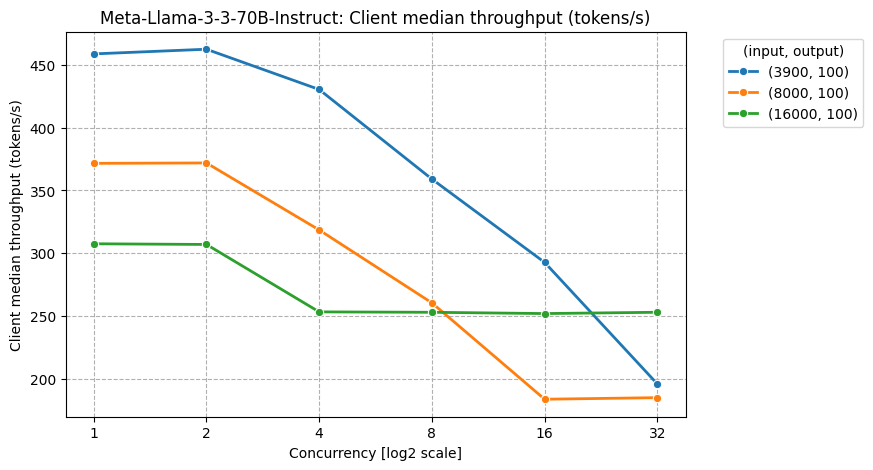

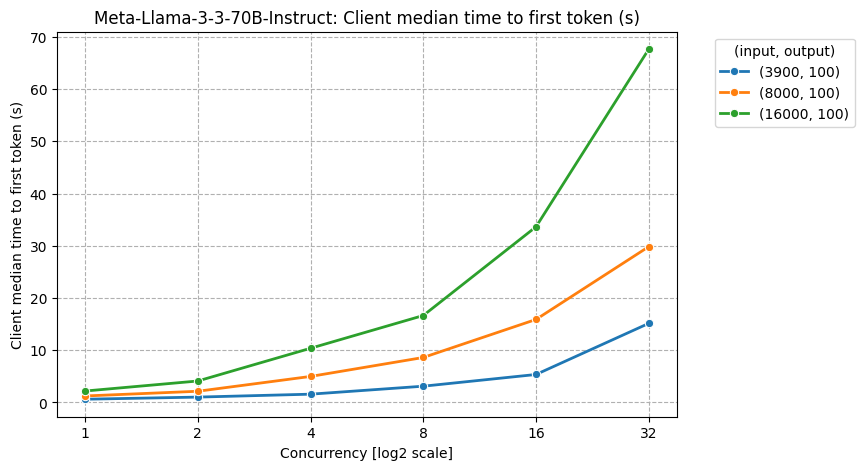

In [17]:
%matplotlib inline
metrics_to_plot = {
    'Client median throughput (tokens/s)': 'server_output_token_per_s_p50',    
    'Client median time to first token (s)': 'client_ttft_s_p50'
}

for model in sorted(df_current["model"].unique()):
    for metric in metrics_to_plot:
        plot_benchmarking_data(df_current[df_current["model"] == model], 
                                metric, 
                                metrics_to_plot[metric], model)

## 7. Compare with alternative benchmarking results

In [18]:
current_name = "DSO Endpoint"
alt_name = "Cloud Master"
df_current["source"] = current_name

#### Read results from alternative source

In [19]:
alt_type = "master" # "run" or "master"

if alt_type == "run":
    alt_run_name = "salesforce_xlam2_70b_short_studio_20250523_1"
    current_file_path = os.path.join(config["consolidated_results_dir"], f'{alt_run_name}.xlsx')
    df_alt = pd.read_excel(current_file_path, sheet_name='Sheet1')
    df_alt = df_alt[df_alt["model"].isin([t.replace('.', '-') for t in target_models])]
    df_alt["source"] = alt_name
    df_alt.head()
if alt_type == "master":
    df_alt = pd.read_excel('~/Downloads/Master_Benchmarking_Sheet.xlsx', sheet_name='Sheet1',  header=0, index_col=[0, 1, 2, 3]).reset_index()
    df_alt = df_alt[df_alt["model"].isin([t.replace('.', '-') for t in target_models])]
    df_alt["source"] = alt_name
    df_alt.head()

#### Combine dataframes

In [20]:
df_current.shape, df_alt.shape

((18, 45), (36, 38))

In [21]:
common_columns = list(set(df_current.columns) & set(df_alt.columns)) # get intersection
common_columns = [c for c in df_current.columns if c in common_columns] # reorder
len(common_columns)

36

In [22]:
first_columns = ['source','model','num_input_tokens','num_output_tokens','num_concurrent_requests']
following_columns = [column for column in common_columns if column not in first_columns]
results = pd.concat([
        df_current,
        df_alt
    ], axis=0
)[first_columns + following_columns]
results["server_rated_throughput"] = results["server_output_token_per_s_p50"] * results["representative_batch_size"]
results["total_latency"] =  results["num_completed_requests"]*60/results["num_completed_requests_per_min"]
results.head()

,source,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size,server_rated_throughput,total_latency
0,DSO Endpoint,Meta-Llama-3-3-70B-Instruct,3900,100,1,0.3801,0.3828,4.8994,0.5897,0.5949,5.1213,325.4260,458.8224,463.3246,NaN,NaN,NaN,3934,100,0.5430,0.6126,5.2633,0.7473,0.8365,5.5294,238.0279,475.8591,969.9172,64,64,64.4285,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,458.8224,59.600953
1,DSO Endpoint,Meta-Llama-3-3-70B-Instruct,3900,100,2,0.3799,0.3821,0.3849,0.5899,0.5922,0.5980,457.8672,462.5537,465.3559,NaN,NaN,NaN,3934,100,0.5554,1.0196,1.1729,0.7643,1.2291,1.5308,195.0505,478.0268,856.4231,64,64,96.5022,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,462.5537,39.791839
2,DSO Endpoint,Meta-Llama-3-3-70B-Instruct,3900,100,4,0.6500,0.6516,5.1575,0.8743,0.8778,5.3891,323.1098,430.4605,433.1878,NaN,NaN,NaN,3934,100,1.5686,1.5795,6.3856,1.7912,1.8032,6.5538,430.0186,448.3687,686.9657,64,64,113.9738,0,{},"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2,860.9210,33.691954
3,DSO Endpoint,Meta-Llama-3-3-70B-Instruct,3900,100,8,0.3802,2.4460,6.9075,0.5888,2.7122,7.1818,280.9163,359.0668,464.0085,NaN,NaN,NaN,3934,100,0.5451,3.1069,7.7410,0.8403,3.3737,8.0678,305.1220,371.9351,925.9842,64,64,121.0767,0,{},"[1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7]","[1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8]",8,2872.5344,31.715433
4,DSO Endpoint,Meta-Llama-3-3-70B-Instruct,3900,100,16,0.3803,4.6587,9.6095,0.5905,4.9827,9.9400,255.0747,292.6676,462.6318,NaN,NaN,NaN,3934,100,0.5731,5.3498,10.5141,0.7836,5.6791,10.8819,270.9471,300.8119,536.2556,64,64,137.3431,0,{},"[1, 15, 1, 15, 1, 15, 1, 15]","[1, 16, 1, 16, 1, 16, 1, 16]",16,4682.6816,27.959177


### Plot benchmarking charts among runs

You may change the pallette color based on the color that better identifies each run. You can take the [following link](https://seaborn.pydata.org/tutorial/color_palettes.html) as reference. Also, you will need to update the suptitle to reflect the model you're showing and any other detail. 

<Figure size 640x480 with 0 Axes>

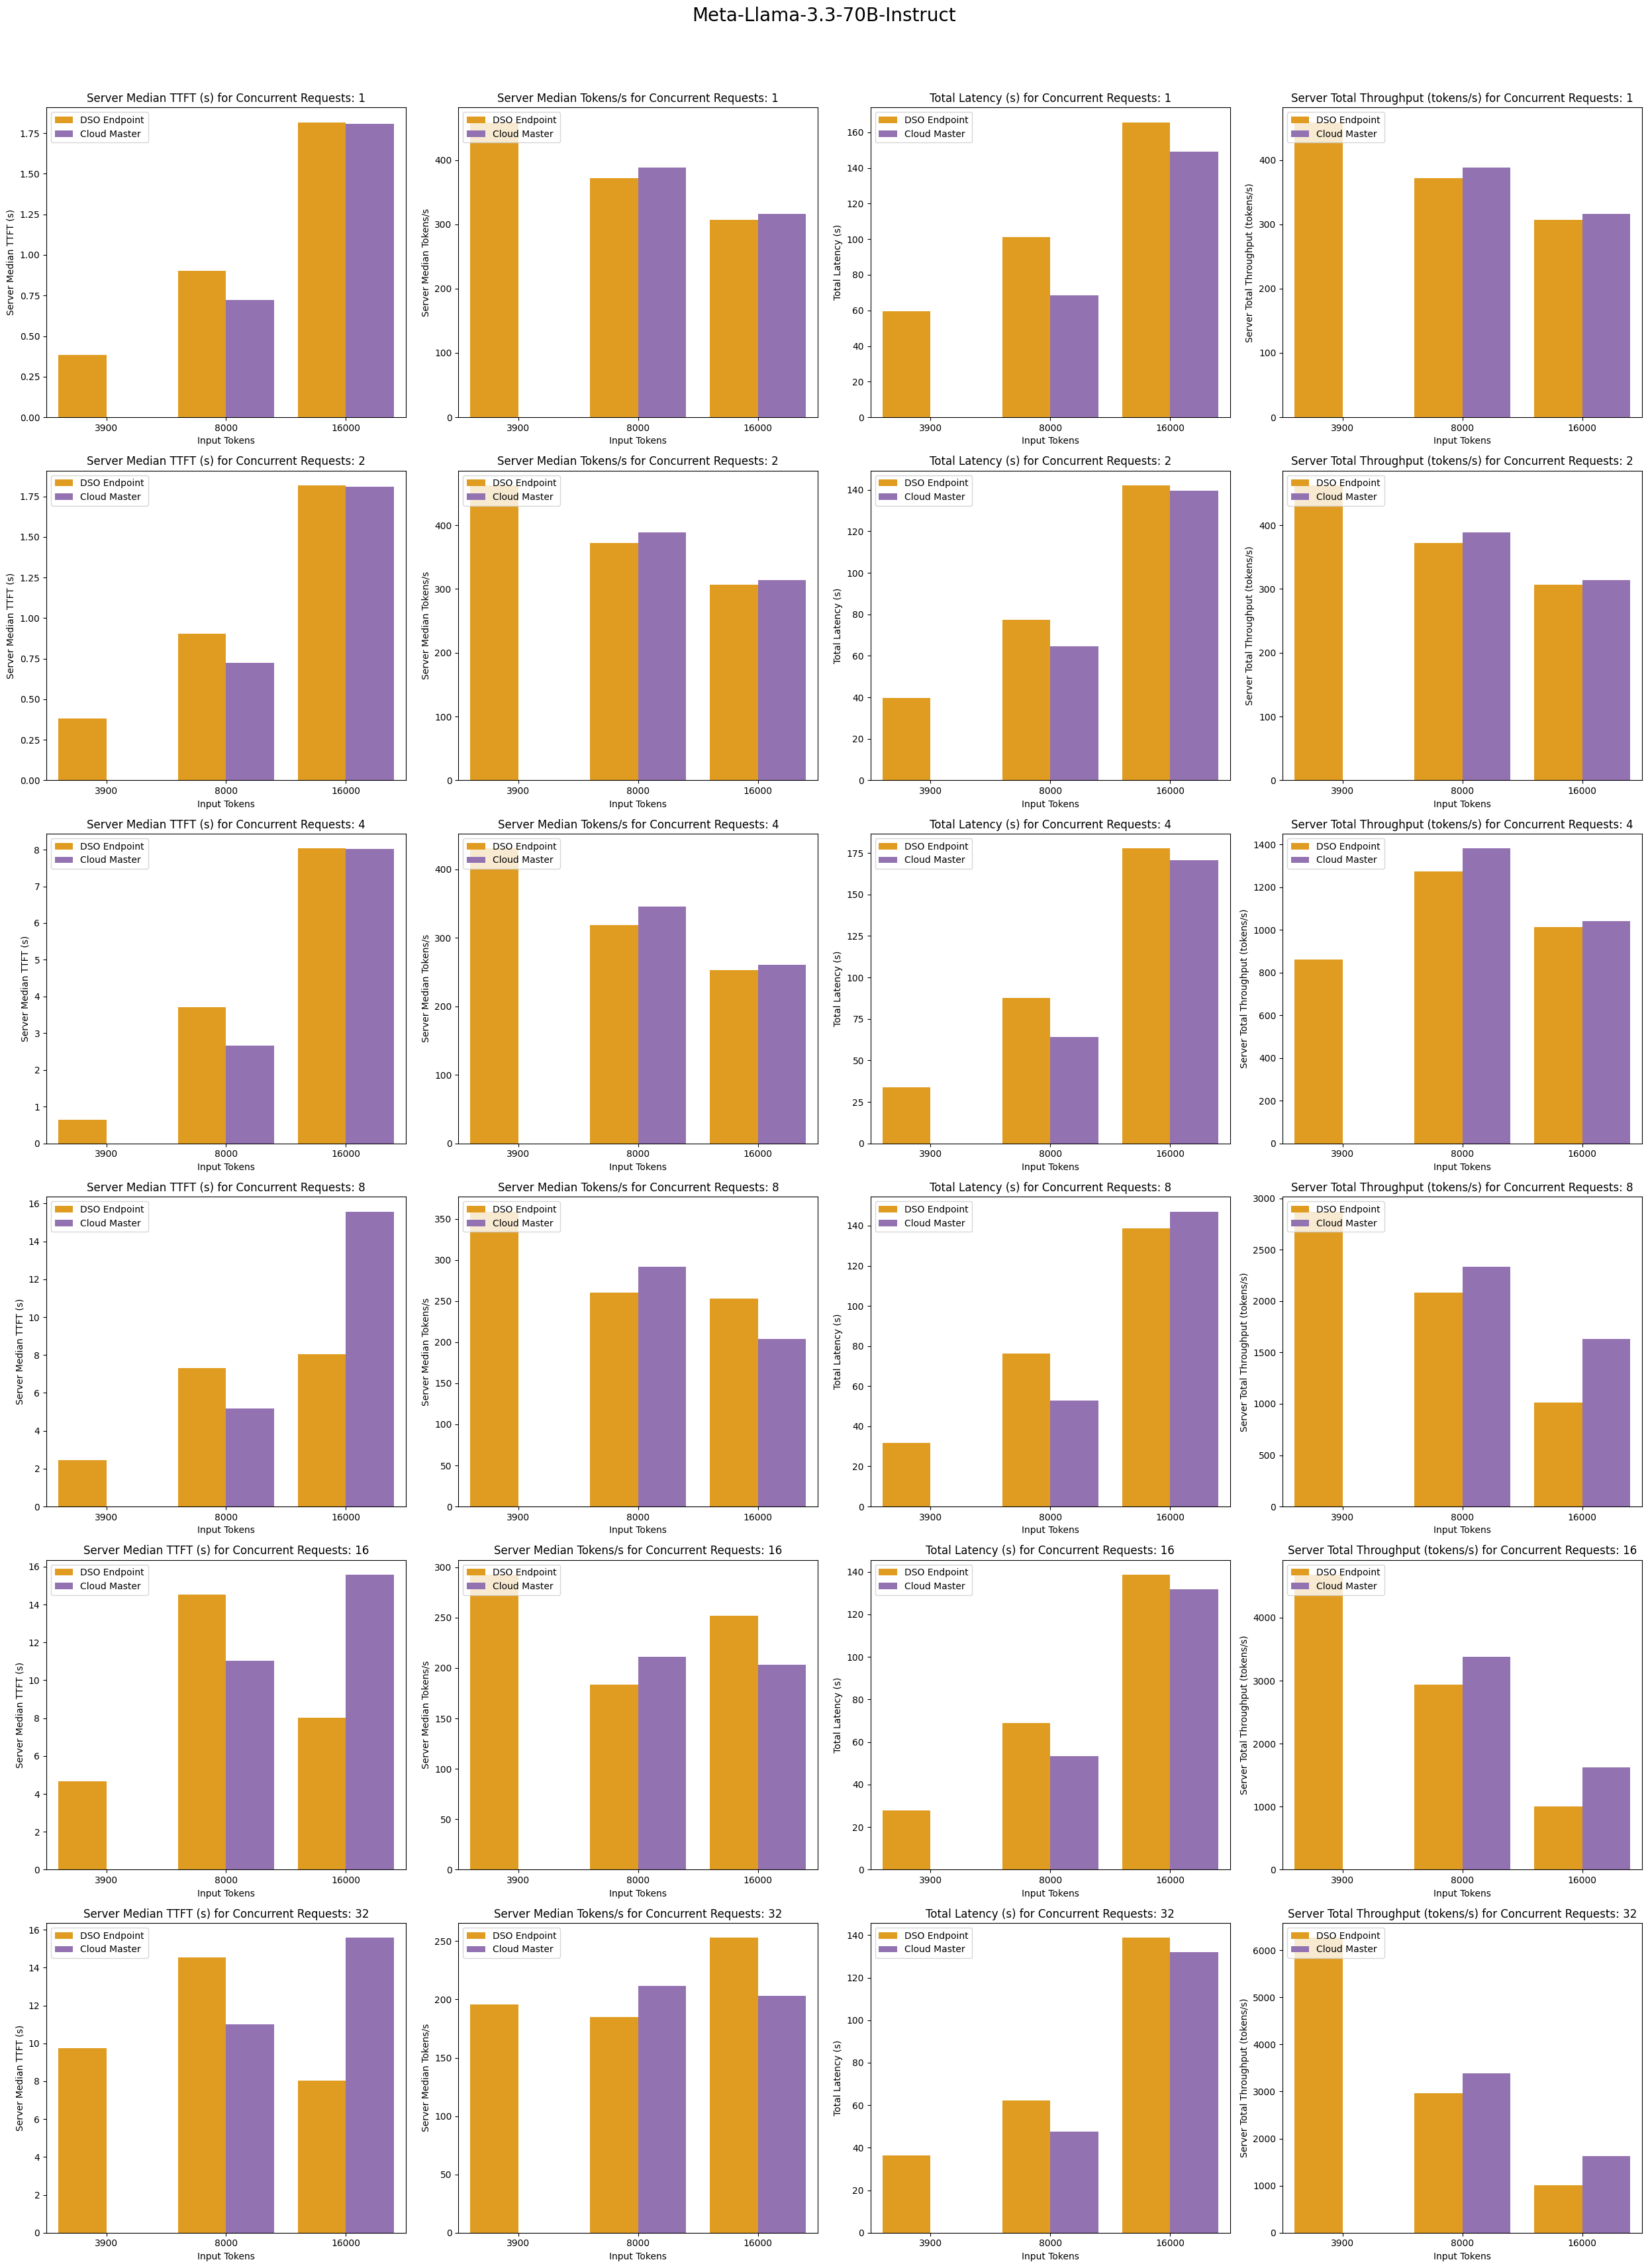

In [23]:
%matplotlib inline

# Pallette for the run, change colors and run names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Server Median TTFT (s)": "server_ttft_s_p50",
    "Server Median Tokens/s": "server_output_token_per_s_p50",
    "Total Latency (s)": "total_latency",
    "Server Total Throughput (tokens/s)": "server_rated_throughput",
}

# Get unique concurrent values
concurrent_values = sorted(concurrent_requests)
num_input_tokens = input_tokens

plt.clf()
for target_model in target_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), len(fields), figsize=(25, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]   
        subset = subset[subset['num_input_tokens'].isin(num_input_tokens)]     
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='num_input_tokens', y=fields[field], hue='source', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()